# MS Imaging 4D
Co-visualization of intraoperative REIMS/navigation\
Amoon, Feb 2024

## steps
&bull; Nav-i-knife temporal registration\
 &bull; Tube/Heatmap visualization

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import matplotlib.cm as cm

def decomp_to_vec(word):
    word = word.replace(']','')
    word = word.replace('[','')
    word = word.split(' ')
    out = []
    for letter in word:
        try:
            out.append(float(letter))
        except:
            pass
    out = np.array(out)
    out.shape = (1,-1)
    return out

## chromatogram
Time, scan number, abundance

In [3]:
## load chromatogram
file_loc = r"case16"
file_chr = r"case16.xlsx"
df_chr = pd.read_excel( os.path.join(file_loc, file_chr) )
df_chr.head()

,Time(min),Abundance,Unnamed: 2,Scan (No.),Abundance.1
0,0.034,199845648,NaN,1,199845648
1,0.051,202354464,NaN,2,202354464
2,0.067,212733072,NaN,3,212733072
3,0.084,205411648,NaN,4,205411648
4,0.101,208282496,NaN,5,208282496


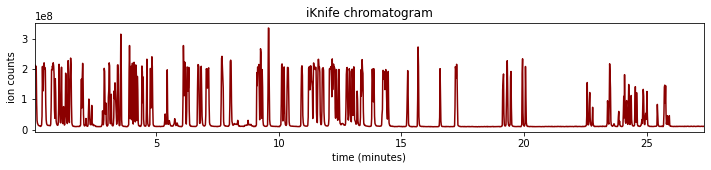

In [4]:
chrom = df_chr[df_chr.columns[1]].values
t_chrom = df_chr[df_chr.columns[0]].values
s_chrom = df_chr[df_chr.columns[3]].values

plt.figure(figsize=(12,2))
plt.plot(t_chrom, chrom, color='darkred')
plt.xlim([t_chrom.min(), t_chrom.max()])
plt.title('iKnife chromatogram')
plt.xlabel('time (minutes)')
plt.ylabel('ion counts')
plt.show()

## navogation 
time, xyz location of cautery tip in needle coordinates, distance to the tumor

In [5]:
## load navigation data
file_nav = "Case16_PosMatrix_Needle.csv"
df_nav = pd.read_csv( os.path.join(file_loc, file_nav) )
df_nav.head()


,Unnamed: 0,Time (s),CauteryTip_Needle,Distance To Tumour (mm)
0,0,14.060,[ 642.45849609 36.23294449 -371.4546814 ],689.259373
1,1,14.136,[ 642.10699463 35.7533226 -371.13424683],688.782087
2,2,14.195,[ 643.04772949 36.81811523 -371.42279053],689.784357
3,3,14.274,[ 642.65112305 37.24766541 -372.76837158],690.078809
4,4,14.334,[ 642.14013672 36.18574905 -373.54766846],689.892569


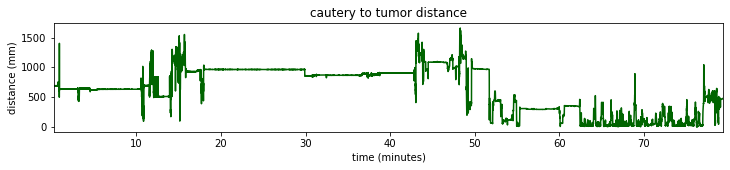

In [6]:
t_nav = df_nav[df_nav.columns[1]].values
t_nav = (t_nav)/60 # convert from seconds to minutes
dist = df_nav[df_nav.columns[3]].values
ctr_tip = df_nav[df_nav.columns[2]].values
ctr_tip = np.concatenate( [decomp_to_vec(x) for x in ctr_tip] )

plt.figure(figsize=(12,2))
plt.plot(t_nav, dist, color='darkgreen')
plt.xlim([t_nav.min(), t_nav.max()])
plt.title('cautery to tumor distance')
plt.xlabel('time (minutes)')
plt.ylabel('distance (mm)')
plt.show()

## automatic sync
based on the determined threshold

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider, FloatSlider, Layout

t_min = np.min([t_nav.min(), t_chrom.min()])
t_max = np.max([t_nav.max(), t_chrom.max()])
t_step = 1/60/20 #20Hz
t_min, t_max, t_step = np.round([t_min, t_max, t_step], 4)
t_comm = np.arange(t_min, t_max, t_step)

interp_chrom = scipy.interpolate.interp1d(t_chrom, chrom, bounds_error=False, fill_value=chrom[-1])
chrom_comm = interp_chrom(t_comm)
chrom_comm = chrom_comm/chrom_comm.max()

interp_nav = scipy.interpolate.interp1d(t_nav, dist, bounds_error=False, fill_value=dist[-1])
nav_comm = interp_nav(t_comm)


def AUtoSynch(dist_thresh, chrom_thresh):
    
    x_chrom = chrom_comm>chrom_thresh
    x_nav = nav_comm<dist_thresh

    x_chrom = 2*x_chrom-1
    x_nav = 2*x_nav-1
    
    corr = scipy.signal.correlate(x_chrom, x_nav)
    lags = scipy.signal.correlation_lags(len(x_chrom), len(x_nav))
    
    time_shift = lags[np.argmax(corr)]*t_step
    time_shift = np.round(time_shift, 3)
    
    plt.figure(figsize=(12,2))
    plt.plot(lags*t_step,corr)
    plt.xlabel('lags (minutes)')
    plt.xlim([lags.min()*t_step, lags.max()*t_step])
    plt.title(f'correlation of normalized TIC>{chrom_thresh} and cautery to tumor distance<{dist_thresh} peaks at {time_shift}', loc='center')
#     print('required temporal shift:',tiem_shift)
    if time_shift>0:
        print(f'nav time = iKnife time minus {time_shift} minutes')
    if time_shift<0:
        print(f'nav time = iKnife time plus {-time_shift} minutes')
    plt.yticks([])
    plt.show()
    
layout = Layout(width='700px')
aa = interact(AUtoSynch,
              dist_thresh = IntSlider(value=40, min=0, max=200, step=1, layout=layout),
              chrom_thresh = FloatSlider(value=0.1, min=0.0, max=1.0,step=0.01, layout=layout))


interactive(children=(IntSlider(value=40, description='dist_thresh', layout=Layout(width='700px'), max=200), F…

nav time = iKnife time plus 62.4232 minutes


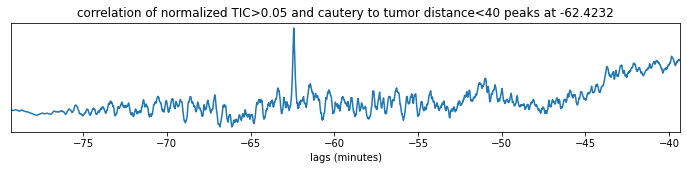

In [8]:

dist_thresh = 40
chrom_thresh = 0.05

x_chrom = chrom_comm>chrom_thresh
x_nav = nav_comm<dist_thresh

x_chrom = 2*x_chrom-1
x_nav = 2*x_nav-1

corr = scipy.signal.correlate(x_chrom, x_nav)
lags = scipy.signal.correlation_lags(len(x_chrom), len(x_nav))

ind = 50000
corr = corr[:ind]
lags = lags[:ind]

time_shift = lags[np.argmax(corr)]*t_step
time_shift = np.round(time_shift, 4)

plt.figure(figsize=(12,2))
plt.plot(lags*t_step,corr)
plt.xlabel('lags (minutes)')
plt.xlim([lags.min()*t_step, lags.max()*t_step])
plt.title(f'correlation of normalized TIC>{chrom_thresh} and cautery to tumor distance<{dist_thresh} peaks at {time_shift}', loc='center')
#     print('required temporal shift:',tiem_shift)
if time_shift>0:
    print(f'nav time = iKnife time minus {time_shift} minutes')
if time_shift<0:
    print(f'nav time = iKnife time plus {-time_shift} minutes')
plt.yticks([])
plt.show()

## Manual check

In [9]:
import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider, FloatSlider, Layout

# def dist_thresholding(t_nav, dist, dist_thresh):
#     plt.figure(figsize=(12,2))
#     plt.plot(t_nav, dist<dist_thresh)
#     plt.xlim([t_nav.min(), t_nav.max()])
#     plt.show()
# aa = interact(dist_thresholding, t_nav = fixed(t_nav), dist = fixed(dist), dist_thresh=(0, 100))

def dist_thresholding(shift, dist_thresh, t_start, t_width):
    plt.figure(figsize=(12,2))
    plt.title('chromatogram', loc='left')
    plt.plot(t_chrom, chrom/chrom.max())
    plt.xlim([t_start,t_start+t_width])
    plt.yticks([])
    plt.figure(figsize=(12,2))
    plt.title('cautery in '+str(dist_thresh)+' mm vicinity of tumor', loc='left')
    plt.plot(t_nav + shift, dist<dist_thresh)
#     plt.plot(t_nav + shift, dist/dist.max())
    plt.xlim([t_start,t_start+t_width])
    plt.yticks([])
    plt.xlabel('time (minutes)')
    plt.show()
#     plt.figure(figsize=(12,2))
#     plt.plot(t_chrom, chrom/chrom.max())
#     plt.plot(t_nav + shift, dist<dist_thresh)
#     plt.xlim([t_start,t_start+t_width])
#     plt.show()

layout = Layout(width='700px')
aa = interact(dist_thresholding,
              shift = FloatSlider(value=-62.42, min=-70, max=-60,step=0.01, layout=layout),
              dist_thresh = IntSlider(value=30, min=0, max=200, step=1, layout=layout),
              t_start = IntSlider(value=7, min=0, max=30, step=1, layout=layout),
              t_width = IntSlider(value=6, min=4, max=50, step=1, layout=layout),)

interactive(children=(FloatSlider(value=-62.42, description='shift', layout=Layout(width='700px'), max=-60.0, …

In [10]:
print(time_shift)

-62.4232


## create synched navigation with heatmap
temporal registration

In [29]:
### poly tube generation

import vtk

def create_tube_from_RAS_points(points, colors, radius=1, num_sides=12):
    # Convert points from RAS to LPS
    points = np.array([-points[:, 0], -points[:, 1], points[:, 2]]).T
    
    # Create a polyline from the points
    vtk_points = vtk.vtkPoints()
    polyline = vtk.vtkPolyLine()
    polyline.GetPointIds().SetNumberOfIds(len(points))

    # Add points to vtkPoints and set point ids for the polyline
    for i, point in enumerate(points):
        vtk_points.InsertNextPoint(point)
        polyline.GetPointIds().SetId(i, i)

    # Create a cell array to store the polyline
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polyline)

    # Create polydata and add the points and polyline
    poly_data = vtk.vtkPolyData()
    poly_data.SetPoints(vtk_points)
    poly_data.SetLines(cells)

    # Add colors
    color_array = vtk.vtkUnsignedCharArray()
    color_array.SetNumberOfComponents(4)  # RGBA
    color_array.SetName("Colors")
    for color in colors:
        color_array.InsertNextTuple([int(c * 255) for c in color])
    poly_data.GetPointData().SetScalars(color_array)

    # Create tubes from the polyline
    tube_filter = vtk.vtkTubeFilter()
    tube_filter.SetInputData(poly_data)
    tube_filter.SetRadius(radius)
    tube_filter.SetNumberOfSides(num_sides)
    tube_filter.CappingOn()
    tube_filter.Update()

    return tube_filter.GetOutput()

def read_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b', 'a']].values
    return points, colors

def create_vtp_model(yarn_file, file_loc):
    # Read points and colors from CSV
    csv_file_path = os.path.join(file_loc, yarn_file+'.csv')

    points, colors = read_data_from_csv(csv_file_path)

    # Create tube model
    tube_poly_data = create_tube_from_RAS_points(points, colors)

    # Save as a VTP file
    vtp_writer = vtk.vtkXMLPolyDataWriter()
    vtp_writer.SetFileName( os.path.join(file_loc, yarn_file+'.vtp') )  # Replace with desired output path
    vtp_writer.SetInputData(tube_poly_data)
    vtp_writer.Write()
    
def merge_location_and_color(df_location, df_color):
    # Ensure timestamps are sorted
    df_location.sort_values('t', inplace=True)
    df_color.sort_values('t', inplace=True)

    # Initialize color columns in df_location with default values
    for color in ['r', 'g', 'b', 'a']:
        df_location[color] = 0

    # Iterate through location dataframe and assign colors
    color_idx = 0
    for i, row in df_location.iterrows():
        while color_idx < len(df_color) - 1 and df_color.at[color_idx + 1, 't'] <= row['t']:
            color_idx += 1
        for color in ['r', 'g', 'b', 'a']:
            df_location.at[i, color] = df_color.at[color_idx, color]

    return df_location

In [30]:
### volumetric heatmap generation

import vtk
import SimpleITK as sitk
from vtk.util import numpy_support

def read_vtk_polydata(filename):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()
    return reader.GetOutput()

def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, line_diameter):
    # Initialize the volume and count matrices
    volume = np.zeros((*dimensions, 4), dtype=np.float32)  # For RGBA values
    count = np.zeros(dimensions, dtype=np.int32)  # For counting contributions to each voxel
    
    # Extract points and color data from vtkPolyData
    points = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
    colors = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

    # Helper functions
    def add_color_to_volume(voxel, color, volume, count, dimensions):
        if np.all(np.array(voxel) >= 0) and np.all(np.array(voxel) < np.array(dimensions)):
            volume[voxel] += color
            count[voxel] += 1

    
    def point_to_voxel(point, origin, spacing, dimensions):
        voxel = np.floor((np.array(point) - np.array(origin)) / np.array(spacing)).astype(int)
        return np.clip(voxel, [0, 0, 0], np.array(dimensions) - 1)
    
    def rasterize_line(p1, p2, color, diameter, volume, count, origin, spacing, dimensions):
        p1_voxel = point_to_voxel(p1, origin, spacing, dimensions)
        p2_voxel = point_to_voxel(p2, origin, spacing, dimensions)
        steps = max(int(np.ceil(np.linalg.norm(p2_voxel - p1_voxel))), 1)

        for step in range(steps + 1):
            t = step / steps
            voxel = p1_voxel + t * (p2_voxel - p1_voxel)
            voxel_rounded = tuple(np.round(voxel).astype(int))

            for dx in range(-diameter, diameter + 1):
                for dy in range(-diameter, diameter + 1):
                    for dz in range(-diameter, diameter + 1):
                        voxel_offset = (voxel_rounded[0] + dx, voxel_rounded[1] + dy, voxel_rounded[2] + dz)
                        add_color_to_volume(voxel_offset, color, volume, count, dimensions)

    # Rasterize points and lines
    for i in range(len(points) - 1):
        color = colors[i]  # Assuming colors are associated with points
        if colors[i,3]!=0 or colors[i+1,3]!=0:
            rasterize_line(points[i], points[i+1], color, line_diameter, volume, count, origin, spacing, dimensions)

    # Average the color values where there's been more than one contribution
    nonzero = count > 0
    volume[nonzero] /= count[nonzero][:, None]

    return volume.astype(np.uint8)

def rasterize_tubes_nodes(vtk_polydata, origin, spacing, dimensions):
    # Create an empty multi-component volume for RGBA data
    volume = np.zeros((*dimensions, 4), dtype=np.float32)  # 4 for RGBA
    count = np.zeros(dimensions, dtype=np.int32)

    # Setup the tube filter
    tubes = vtk.vtkTubeFilter()
    tubes.SetInputData(vtk_polydata)
    tubes.SetRadius(0.5)  # Radius of the tubes
    tubes.SetNumberOfSides(12)
    tubes.CappingOn()
    tubes.Update()

    # Get the bounds of the tube data
    bounds = tubes.GetOutput().GetBounds()

    # Iterate through each voxel in the volume
    for k in range(dimensions[2]):  # z
        for j in range(dimensions[1]):  # y
            for i in range(dimensions[0]):  # x
                # Convert voxel index to world coordinates
                x = i * spacing[0] + origin[0]
                y = j * spacing[1] + origin[1]
                z = k * spacing[2] + origin[2]

                # Check if the point is within the bounds of the tube data
                if (bounds[0] <= x <= bounds[1] and
                    bounds[2] <= y <= bounds[3] and
                    bounds[4] <= z <= bounds[5]):

                    # Check if the point is close to the tube surface
                    point_id = tubes.GetOutput().FindPoint([x, y, z])
                    if point_id >= 0:
                        color = numpy_support.vtk_to_numpy(tubes.GetOutput().GetPointData().GetScalars()).take(point_id, axis=0)
                        volume[i, j, k, :] += color
                        count[i, j, k] += 1

    # Average the color values
    non_zero_count = count > 0
    volume[non_zero_count] /= count[non_zero_count][:, None]

    return volume.astype(np.uint8)

def create_sitk_image_from_volume(volume, spacing, origin, kernel_size_c=None):
    volume_reorder = np.transpose(volume, (2, 1, 0, 3))  # Reordering to (x, y, z, channels)
    sitk_image = sitk.GetImageFromArray(volume_reorder, isVector=True)
    sitk_image.SetSpacing(spacing)
    sitk_image.SetOrigin(origin)
    
    # Apply Gaussian smoothing
    if kernel_size_c!=None:
        gaussian_filter = sitk.SmoothingRecursiveGaussianImageFilter()
        gaussian_filter.SetSigma(kernel_size_c)
        sitk_image = gaussian_filter.Execute(sitk_image)
    
    return sitk_image

def create_heatmap_from_vtk_polydata(vtp_file, origin, spacing, dimensions, tube_diameter, smoothing_kernel=None, node_only=False):
    # Load the VTK tube model
    vtk_polydata = read_vtk_polydata(vtp_file)

    # Rasterize the model with color averaging
    if node_only:
        volume_with_color = rasterize_tubes_nodes(vtk_polydata, origin, spacing, dimensions)
    else:
        volume_with_color = rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, tube_diameter)

    # Create a SimpleITK image
    sitk_image = create_sitk_image_from_volume(volume_with_color, spacing, origin, smoothing_kernel)

    return sitk_image

In [31]:
### get info from tumor model

def cog_range_from_vtk_model(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    num_points = points.GetNumberOfPoints()
    
    # Convert points to NumPy array and change from LPS to RAS by negating the X and Y coordinates
    coords = np.array([(-points.GetPoint(i)[0], -points.GetPoint(i)[1], points.GetPoint(i)[2]) for i in range(num_points)])
    
    # Calculate the center of gravity in RAS
    center_of_gravity = np.mean(coords, axis=0)
    
    # Calculate the full range along each axis in RAS
    x_range = np.max(coords[:,0]) - np.min(coords[:,0])
    y_range = np.max(coords[:,1]) - np.min(coords[:,1])
    z_range = np.max(coords[:,2]) - np.min(coords[:,2])
    
    return center_of_gravity, x_range, y_range, z_range


##### heatmap data from navigation

In [36]:
criteria_time = 15  ## min
criteria_speed = 100000  ## mm/s
criteria_dist = 50 ## mm

df_location = pd.DataFrame(columns=['t','x','y','z','d','r','g','b','a'])
df_location['t'] = t_nav + time_shift
df_location[['x','y','z']] = ctr_tip
df_location['d'] = dist

df_location = df_location[df_location['t']>=0]
df_location = df_location[df_location['t']<=criteria_time]

df_location[['r','g','b','a']] = cm.get_cmap('jet')(df_location['t']/df_location['t'].max())

speed = np.sum( np.diff(df_location[['x','y','z']],axis=0)**2, axis=1)
speed = speed/np.diff(df_location['t'],axis=0)
speed = np.concatenate([speed[0].reshape(1,), speed])
df_location['a'][speed>criteria_speed] = 0

df_location['a'][df_location['d']>criteria_dist] = 0

yarn_file = r'navigation_time_criteria'
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

In [114]:
# Define properties for the output volume

# Path to model
tumorModel_path = os.path.join(file_loc, 'TumorModel.vtk')
# calculate center of gravity, and range
tomor_center, x_range, y_range, z_range = cog_range_from_vtk_model(tumorModel_path)
cube_range = (x_range+2*criteria_dist, y_range+2*criteria_dist, z_range+2*criteria_dist)

# tomor_center = (-15, 0, -70)
# cube_range = (100,100,100)
print(tomor_center, cube_range)

spacing = (1, 1, 1)  
origin = tuple([x-y/2 for (x,y) in zip(tomor_center, cube_range)])
dimensions = tuple([int(x//y) for (x,y) in zip(cube_range, spacing)])
tube_diameter = 1
smoothing_kernel = None

# Load the VTK tube model
vtp_file = os.path.join(file_loc, yarn_file+'.vtp')

sitk_image = create_heatmap_from_vtk_polydata(vtp_file, origin, spacing, dimensions, tube_diameter, smoothing_kernel, node_only=False)

# Save the image
output_filename = os.path.join(file_loc, yarn_file+'.nii')
sitk.WriteImage(sitk_image, output_filename)


[-12.41739836  -0.88076895 -71.01107557] (77.08816051483154, 80.21756553649902, 79.0199089050293)


##### heatmap from iKnife

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
def tic_normalize(peaks):
    tot_ion_cur = np.sum(peaks, axis=1)
    peaks_ticn = np.empty(peaks.shape)
    for i in range(len(peaks)):
        if tot_ion_cur[i]!=0:
            peaks_ticn[i] = peaks[i]/tot_ion_cur[i]
    return peaks_ticn

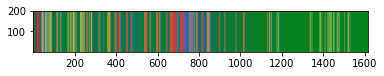

In [79]:
## targeted ion heatmap
## load iKnife raw
file_spectra = "case16_raw1.csv"
df_spectra = pd.read_csv( os.path.join(file_loc, file_spectra) )
peaks = df_spectra[df_spectra.columns[5:]].values
peaks = tic_normalize(peaks)
peaks = MinMaxScaler().fit_transform(peaks)

# ion = 893
# ind_ion = int(ion-100)

# plt.figure(figsize=(8,2))
# plt.plot(t_chrom,peaks[:,ind_ion])
# plt.show()

# pca = PCA(n_components=3).fit(peaks[chrom/chrom.max()>criteria_tic])
# scaler = MinMaxScaler().fit(pca.transform(peaks[chrom/chrom.max()>criteria_tic]))
# peaks_pca = pca.transform(peaks)
# peaks_pca = scaler.transform(peaks_pca)
# peaks_pca = np.clip(peaks_pca, 0,1)

peaks_pca = PCA(n_components=3).fit_transform(peaks)
peaks_pca = MinMaxScaler().fit_transform(peaks_pca)

plt.imshow(peaks_pca.reshape(1,-1,3), extent=[1,1616,1,200])


In [93]:
## load iKnife classification
file_class = "case16_Martin_heatmap.csv"
df_class = pd.read_csv( os.path.join(file_loc, file_class) )
df_class.head()
class_pred = df_class['Classification']
heatmap_data = []
for class_read in df_class['Classification']:
    if class_read=='tumor1':
        heatmap_data.append([[1,0,0,1]])
#         heatmap_data.append([[0,0,0,0]])
    else:
        heatmap_data.append([[0,1,0,1]])
#         heatmap_data.append([[0,0,0,0]])
heatmap_data = np.concatenate(heatmap_data)

In [112]:
## load iKnife classification
file_class = "case16_Martin_heatmap.csv"
df_class = pd.read_csv( os.path.join(file_loc, file_class) )
df_class.head()

scan_no = df_class['Start scan']
class_pred = df_class['Class name']
non_nan_ind = ~np.isnan(scan_no)
scan_no = scan_no[non_nan_ind]
class_pred = class_pred[non_nan_ind]
np.unique(class_pred)

heatmap_data = np.zeros([len(t_chrom),4])
for i,j in zip(scan_no, class_pred):
    if j=='tumor1':
        heatmap_data[int(i)] = np.array([1,0,0,1])
#     elif j=='tumor1 cut':
#         heatmap_data[int(i)] = np.array([1,0,0,1])
#     elif j=='Skin intraop':
#         heatmap_data[int(i)] = np.array([1,1,0,1])
#     elif j=='normal' or j=='normal cut':
#         heatmap_data[int(i)] = np.array([0,1,0,1])
        

In [113]:
# criteria_tic = 0.05  ## normaliozed ratio
# criteria_time = 15  ## min
# criteria_speed = 100000  ## mm/s
# criteria_dist = 50 ## mm

criteria_tic = 0.05  ## normaliozed ratio
criteria_time = 15  ## min
criteria_speed = 15000  ## mm/s
criteria_dist = 30 ## mm

df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom

# df_iknife[['r','g','b','a']] = cm.get_cmap('jet')(t_chrom/criteria_time) #/t_chrom.max()*1.5)

# df_iknife[['r','g','b','a']] = cm.get_cmap('plasma')(chrom/chrom.max()) 
# df_iknife['a'] = np.clip( chrom/chrom.max() ,0,1)

# df_iknife[['r','g','b','a']] = cm.get_cmap('Reds')(peaks[:,ind_ion])
# df_iknife[['r','g','b','a']] = 0
# df_iknife['a'] =1
# df_iknife['g'] = np.clip( peaks[:,ind_ion] ,0,1)
# df_iknife['g'] = np.clip( peaks[:,int(893-100)] ,0,1)
# df_iknife['r'] = np.clip( peaks[:,int(744-100)] ,0,1)
# a_intercept = 0.2
# df_iknife['a'] = np.clip( (1+a_intercept)*peaks[:,ind_ion]-a_intercept,0,1)
# df_iknife['a'] = np.clip( np.clip( (1+a_intercept)*peaks[:,int(893-100)]-a_intercept,0,1) + np.clip( (1+a_intercept)*peaks[:,int(744-100)]-a_intercept,0,1) ,0,1)

# df_iknife[['r','g','b']] = peaks_pca
# df_iknife['a'] =1
# df_iknife['a'] = np.clip( chrom/chrom.max() ,0,1)

df_iknife[['r','g','b','a']] = heatmap_data

df_iknife['a'][chrom/chrom.max()<criteria_tic] = 0

df_location = pd.DataFrame(columns=['t','x','y','z','d'])
df_location['t'] = t_nav + time_shift
df_location[['x','y','z']] = ctr_tip
df_location['d'] = dist

df_location = df_location[df_location['t']>=0]
df_location = df_location[df_location['t']<=criteria_time]

df_location = merge_location_and_color(df_location, df_iknife)

speed = np.sum( np.diff(df_location[['x','y','z']],axis=0)**2, axis=1)
speed = speed/np.diff(df_location['t'],axis=0)
speed = np.concatenate([speed[0].reshape(1,), speed])
df_location['a'][speed>criteria_speed] = 0

df_location['a'][df_location['d']>criteria_dist] = 0

yarn_file = r'iknife_advanceCancer_criteria'
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

C:\Users\jamzad\AppData\Local\Temp/ipykernel_31880/213103002.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location['a'][speed>criteria_speed] = 0
C:\Users\jamzad\AppData\Local\Temp/ipykernel_31880/213103002.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location['a'][df_location['d']>criteria_dist] = 0


### Test runs


In [554]:
## load iKnife classification
file_class = "case16_Martin_heatmap.csv"
df_class = pd.read_csv( os.path.join(file_loc, file_class) )
df_class.head()
class_pred = df_class['Classification']
heatmap_data = []
for class_read in df_class['Classification']:
    if class_read=='tumor1':
        heatmap_data.append([[1,0,0,1]])
#         heatmap_data.append([[0,0,0,0]])
    else:
#         heatmap_data.append([[0,1,0,0.7]])
        heatmap_data.append([[0,0,0,0]])
heatmap_data = np.concatenate(heatmap_data)
# heatmap_data[chrom/chrom.max()<0.05] = [0,0,0,0]


In [162]:
heatmap_data = cm.get_cmap('jet')(t_chrom/t_chrom.max()*1.5)
heatmap_data[chrom/chrom.max()<0.05] = [0,0,0,0]

In [555]:
criteria_tic = 0.08  ## normaliozed ratio
criteria_time = 15  ## min
criteria_speed = 15000  ## mm/s
criteria_dist = 30 ## mm

df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom
df_iknife[['r','g','b','a']] = heatmap_data

df_iknife['a'][chrom/chrom.max()<criteria_tic] = 0

df_location = pd.DataFrame(columns=['t','x','y','z','d'])
df_location['t'] = t_nav - 62.4264
df_location[['x','y','z']] = ctr_tip
df_location['d'] = dist
df_location = df_location[df_location['t']>=0]
df_location = df_location[df_location['t']<=criteria_time]
# df_location = df[['t','x','y','z']]

df_location = merge_location_and_color(df_location, df_iknife)

speed = np.sum( np.diff(df_location[['x','y','z']],axis=0)**2, axis=1)
speed = speed/np.diff(df_location['t'],axis=0)
speed = np.concatenate([speed[0].reshape(1,), speed])
df_location['a'][speed>criteria_speed] = 0

df_location['a'][df_location['d']>criteria_dist] = 0

yarn_file = r'iknife_cancer4264'
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/1068257176.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iknife['a'][chrom/chrom.max()<criteria_tic] = 0
C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/1068257176.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location['a'][speed>criteria_speed] = 0
C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/1068257176.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/2300596140.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iknife['a'][chrom/chrom.max()<0.05] = 0


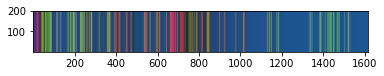

In [299]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
def tic_normalize(peaks):
    tot_ion_cur = np.sum(peaks, axis=1)
    peaks_ticn = np.empty(peaks.shape)
    for i in range(len(peaks)):
        if tot_ion_cur[i]!=0:
            peaks_ticn[i] = peaks[i]/tot_ion_cur[i]
    return peaks_ticn

## load iKnife raw
file_spectra = "case16_raw1.csv"
df_spectra = pd.read_csv( os.path.join(file_loc, file_spectra) )
peaks = df_spectra[df_spectra.columns[5:]].values
peaks = tic_normalize(peaks)
peaks = MinMaxScaler().fit_transform(peaks)

# peaks_pca = PCA(n_components=3).fit_transform(peaks)
# peaks_pca = MinMaxScaler().fit_transform(peaks_pca)

pca = PCA(n_components=3).fit(peaks[chrom/chrom.max()>0.05])
scaler = MinMaxScaler().fit(pca.transform(peaks[chrom/chrom.max()>0.05]))
peaks_pca = pca.transform(peaks)
peaks_pca = scaler.transform(peaks_pca)
peaks_pca = np.clip(peaks_pca, 0,1)

plt.imshow(peaks_pca.reshape(1,-1,3), extent=[1,1616,1,200])

df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom
df_iknife[['r','g','b']] = peaks_pca
df_iknife['a'] = 1
df_iknife['a'][chrom/chrom.max()<0.05] = 0

df_location = pd.DataFrame(columns=['t','x','y','z'])
df_location['t'] = t_nav - 62.4264
df_location[['x','y','z']] = ctr_tip
df_location = df_location[df_location['t']>=0]
# df_location = df_location[df_location['t']<15]

df_location = merge_location_and_color(df_location, df_iknife)

yarn_file = r'iknife_pca_on'
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

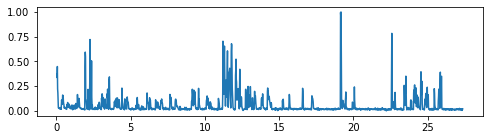

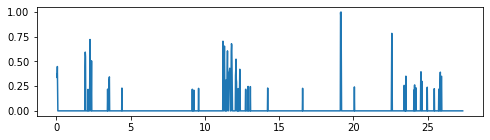

In [324]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
def tic_normalize(peaks):
    tot_ion_cur = np.sum(peaks, axis=1)
    peaks_ticn = np.empty(peaks.shape)
    for i in range(len(peaks)):
        if tot_ion_cur[i]!=0:
            peaks_ticn[i] = peaks[i]/tot_ion_cur[i]
    return peaks_ticn

## load iKnife raw
file_spectra = "case16_raw1.csv"
df_spectra = pd.read_csv( os.path.join(file_loc, file_spectra) )
peaks = df_spectra[df_spectra.columns[5:]].values
peaks = tic_normalize(peaks)
peaks = MinMaxScaler().fit_transform(peaks)

ion = 744
ind_ion = int(ion-100)

plt.figure(figsize=(8,2))
plt.plot(t_chrom,peaks[:,ind_ion])
plt.show()

heatmap_data = cm.get_cmap('Reds')(peaks[:,ind_ion])
heatmap_data = heatmap_data[:,:3]

df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom
df_iknife[['r','g','b']] = heatmap_data
a_intercept = 0.2
df_iknife['a'] = np.clip( (1+a_intercept)*peaks[:,ind_ion]-a_intercept,0,1)
df_iknife['a'][chrom/chrom.max()<0.05] = 0

plt.figure(figsize=(8,2))
plt.plot(t_chrom,peaks[:,ind_ion]*(chrom/chrom.max()>0.05)*(peaks[:,ind_ion]>a_intercept))
plt.show()

df_location = pd.DataFrame(columns=['t','x','y','z'])
df_location['t'] = t_nav - 62.4264
df_location[['x','y','z']] = ctr_tip
df_location = df_location[df_location['t']>=0]
# df_location = df_location[df_location['t']<15]

df_location = merge_location_and_color(df_location, df_iknife)

yarn_file = r'iknife_ion_'+str(ion)
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

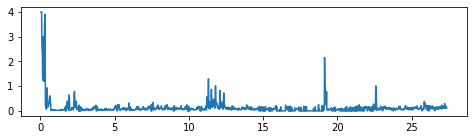

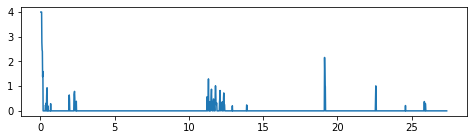

In [444]:
from sklearn.preprocessing import MinMaxScaler

## load iKnife raw
file_class = "case16_Martin_heatmap.csv"
df_class = pd.read_csv( os.path.join(file_loc, file_class) )
df_class.head()

ratio_ind = 1
clip_val = 4
speed_limit = 30

scan_no = df_class[df_class.columns[10]].values
ratio_val = df_class[df_class.columns[10+int(ratio_ind)]].values
non_nan_ind = ~np.isnan(ratio_val)
scan_no = scan_no[non_nan_ind]
ratio_val = ratio_val[non_nan_ind]

ratio_corrected = np.zeros(len(t_chrom))
for i in range(len(scan_no)):
    ratio_corrected[int(scan_no[i]-1)] = ratio_val[i]

ratio_corrected = np.clip(ratio_corrected,0,clip_val)

plt.figure(figsize=(8,2))
plt.plot(t_chrom,ratio_corrected)
plt.show()

heatmap_data = cm.get_cmap('Reds')(ratio_corrected)
heatmap_data = heatmap_data[:,:3]

df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom
df_iknife[['r','g','b']] = heatmap_data
a_intercept = 0.2
df_iknife['a'] = np.clip( (1+a_intercept)*ratio_corrected-a_intercept,0,1)
# df_iknife['a'] = 1
df_iknife['a'][chrom/chrom.max()<0.05] = 0

plt.figure(figsize=(8,2))
plt.plot(t_chrom,ratio_corrected*(chrom/chrom.max()>0.05)*(ratio_corrected>a_intercept))
plt.show()

df_location = pd.DataFrame(columns=['t','x','y','z'])
df_location['t'] = t_nav - 62.4264
df_location[['x','y','z']] = ctr_tip
df_location = df_location[df_location['t']>=0]
# df_location = df_location[df_location['t']<15]

df_location = merge_location_and_color(df_location, df_iknife)

speed = np.sum( np.diff(df_location[['x','y','z']],axis=0)**2, axis=1)
speed = np.concatenate([speed[0].reshape(1,), speed])
df_location['a'][speed>speed_limit] = 0

yarn_file = r'iknife_ratio_'+str(ratio_ind)
df_location.to_csv( os.path.join(file_loc, yarn_file+'.csv') , index=False)
create_vtp_model(yarn_file, file_loc)

(0.0, 10000.0)

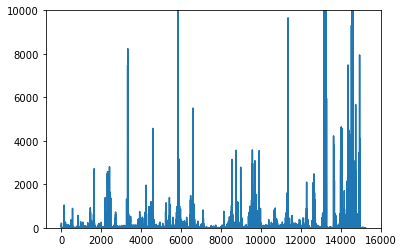

In [428]:
speed = np.sum( np.diff(df_location[['x','y','z']],axis=0)**2, axis=1)
speed = np.concatenate([speed[0].reshape(1,), speed])
plt.plot(speed)
plt.ylim([0,10000])

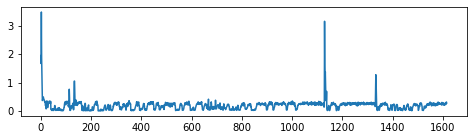

In [292]:
## load iKnife raw
file_spectra = "case16_raw1.csv"
df_spectra = pd.read_csv( os.path.join(file_loc, file_spectra) )
peaks = df_spectra[df_spectra.columns[5:]].values
peaks = tic_normalize(peaks)

plt.figure(figsize=(8,2))
plt.plot(peaks[:,599]/(peaks[:,793]+0.001))
# plt.plot(t_chrom,peaks[:,642])

In [389]:
file_class = "case16_Martin_heatmap.csv"
df_class = pd.read_csv( os.path.join(file_loc, file_class) )
df_class.head()
# plt.figure(figsize=(8,2))
# plt.plot(df_class[df_class.columns[10]].values,
#          df_class[df_class.columns[12]].values,)
# plt.ylim([0,1])
scan_no = df_class[df_class.columns[10]].values
ratio_val = df_class[df_class.columns[11]].values
non_nan_ind = ~np.isnan(ratio_val)
scan_no = scan_no[non_nan_ind]
ratio_val = ratio_val[non_nan_ind]

ratio_corrected = np.zeros(len(t_chrom))
for i in range(len(scan_no)):
    ratio_corrected[int(scan_no[i]-1)] = ratio_val[i]


(1336,)

In [70]:
df_iknife = pd.DataFrame(columns=['t','r','g','b','a'])
df_iknife['t'] = t_chrom
df_iknife[['r','g','b','a']] = cm.get_cmap('jet')(chrom/chrom.max())
df_iknife['a'] = (chrom/chrom.max())
df_iknife['a'][df_iknife['a']<0.1] = 0
df_location = df[['t','x','y','z']]
df_location = merge_location_and_color(df_location, df_iknife)
df_location.to_csv( os.path.join(file_loc, 'navigation_chrom.csv') , index=False)

C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/4206715898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location.sort_values('t', inplace=True)
C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/4206715898.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location[color] = 0
C:\Users\jamzad\AppData\Local\Temp/ipykernel_24224/4206715898.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [547]:
import vtk
import SimpleITK as sitk
import numpy as np
from vtk.util import numpy_support

# def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions):
#     # Create an empty multi-component volume for RGBA data
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)
#     count = np.zeros(dimensions, dtype=np.float32)

#     # Extract points and color data from vtkPolyData
#     points = numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
#     colors = numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

#     # Iterate through the points and fill the volume
#     for i, point in enumerate(points):
#         # Convert LPS to RAS coordinates
#         point_ras = [-point[0], -point[1], point[2]]

#         # Convert RAS coordinates to voxel indices
#         voxel = np.floor((np.array(point_ras) - origin) / spacing).astype(int)
#         if np.all(voxel >= 0) and np.all(voxel < dimensions):
#             voxel = tuple(voxel)
#             volume[voxel] += colors[i]  # Summing colors
#             count[voxel] += 1  # Counting the number of contributions to this voxel

#     # Average the color values
#     nonzero = count > 0
#     volume[nonzero] /= count[nonzero][:, np.newaxis]

#     return volume.astype(np.uint8)

# def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions):
#     # Create an empty multi-component volume for RGBA data
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)
#     count = np.zeros(dimensions, dtype=np.float32)  # To keep track of how many tubes pass through each voxel

#     # Extract points and color data from vtkPolyData
#     points = numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
#     colors = numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())
    
#     # add transparency
# #     colors[:,3] *=0.8
    
#     # Iterate through the points and fill the volume
#     for i, point in enumerate(points):
#         # Convert RAS coordinates to voxel indices
#         voxel = np.floor((np.array(point) - origin) / spacing).astype(int)
#         if np.all(voxel >= 0) and np.all(voxel < dimensions):
#             voxel = tuple(voxel)
#             volume[voxel] += colors[i]  # Summing colors
#             count[voxel] += 1  # Counting the number of contributions to this voxel

#     # Average the color values
#     nonzero = count > 0
#     volume[nonzero] /= count[nonzero][:, np.newaxis]

#     return volume.astype(np.uint8)

import numpy as np
from vtk.util import numpy_support

# def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, line_diameter):
#     # Create an empty multi-component volume for RGBA data
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)
#     count = np.zeros(dimensions, dtype=np.int32)

#     # Extract points and color data from vtkPolyData
#     points = numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
#     colors = numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

#     # Function to convert RAS coordinates to voxel indices
#     def point_to_voxel(point):
#         return np.floor((np.array(point) - origin) / spacing).astype(int)

#     # Function to rasterize a line segment
#     def rasterize_line(p1, p2, color, diameter):
#         p1_voxel = point_to_voxel(p1)
#         p2_voxel = point_to_voxel(p2)
#         length = np.linalg.norm(p2_voxel - p1_voxel)
#         steps = int(np.ceil(length))

#         # Iterate over the line and fill in the voxels
#         for step in range(steps + 1):
#             t = step / steps
#             voxel = p1_voxel + t * (p2_voxel - p1_voxel)
#             voxel = tuple(np.round(voxel).astype(int))

#             # Fill in the voxels within the diameter of the line
#             for dx in range(-diameter, diameter + 1):
#                 for dy in range(-diameter, diameter + 1):
#                     for dz in range(-diameter, diameter + 1):
#                         voxel_offset = (voxel[0] + dx, voxel[1] + dy, voxel[2] + dz)
#                         if all(0 <= v < d for v, d in zip(voxel_offset, dimensions)):
#                             volume[voxel_offset] += color
#                             count[voxel_offset] += 1

#     # Rasterize each point and line
#     for i, point in enumerate(points):
#         voxel = point_to_voxel(point)
#         if np.all(voxel >= 0) and np.all(voxel < dimensions):
#             volume[tuple(voxel)] += colors[i]
#             count[tuple(voxel)] += 1

#         # Rasterize line to the next point
#         if i < len(points) - 1:
#             next_point = points[i + 1]
#             rasterize_line(point, next_point, colors[i], line_diameter)

#     # Average the color values
#     nonzero = count > 0
#     volume[nonzero] /= count[nonzero][:, np.newaxis]

#     return volume.astype(np.uint8)

# ... rest of the code ...


def read_vtk_polydata(filename):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()
    return reader.GetOutput()

# def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions):
#     # Create an empty multi-component volume for RGBA data
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)
#     count = np.zeros(dimensions, dtype=np.float32)  # To keep track of how many tubes pass through each voxel

#     # Extract points and color data from vtkPolyData
#     points = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
#     colors = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

#     # Iterate through the points and fill the volume
#     for i, point in enumerate(points):
#         # Convert RAS coordinates to voxel indices
#         voxel = np.floor((np.array(point) - origin) / spacing).astype(int)
#         if np.all(voxel >= 0) and np.all(voxel < dimensions):
#             voxel = tuple(voxel)
#             volume[voxel] += colors[i]  # Summing colors
#             count[voxel] += 1  # Counting the number of contributions to this voxel

#     # Average the color values
#     nonzero = count > 0
#     volume[nonzero] /= count[nonzero][:, np.newaxis]

#     return volume.astype(np.uint8)

# def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, line_diameter):
#     # Create an empty multi-component volume for RGBA data
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)
#     count = np.zeros(dimensions, dtype=np.int32)

#     # Extract points and color data from vtkPolyData
#     points = numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
#     colors = numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

#     # Function to convert RAS coordinates to voxel indices
#     def point_to_voxel(point):
#         return np.floor((np.array(point) - origin) / spacing).astype(int)

#     # Function to rasterize a line segment
#     def rasterize_line(p1, p2, color, diameter):
#         p1_voxel = point_to_voxel(p1)
#         p2_voxel = point_to_voxel(p2)
#         length = np.linalg.norm(p2_voxel - p1_voxel)
#         steps = int(np.ceil(length))

#         # Iterate over the line and fill in the voxels
#         for step in range(steps + 1):
#             t = step / steps
#             voxel = p1_voxel + t * (p2_voxel - p1_voxel)
#             voxel = tuple(np.round(voxel).astype(int))

#             # Fill in the voxels within the diameter of the line
#             for dx in range(-diameter, diameter + 1):
#                 for dy in range(-diameter, diameter + 1):
#                     for dz in range(-diameter, diameter + 1):
#                         voxel_offset = (voxel[0] + dx, voxel[1] + dy, voxel[2] + dz)
#                         if all(0 <= v < d for v, d in zip(voxel_offset, dimensions)):
#                             volume[voxel_offset] += color
#                             count[voxel_offset] += 1

#     # Rasterize each point and line
#     for i, point in enumerate(points):
#         voxel = point_to_voxel(point)
#         if np.all(voxel >= 0) and np.all(voxel < dimensions):
#             volume[tuple(voxel)] += colors[i]
#             count[tuple(voxel)] += 1

#         # Rasterize line to the next point
#         if i < len(points) - 1:
#             next_point = points[i + 1]
#             rasterize_line(point, next_point, colors[i], line_diameter)

#     # Average the color values
#     nonzero = count > 0
#     volume[nonzero] /= count[nonzero][:, np.newaxis]

#     return volume.astype(np.uint8)

def rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, line_diameter):
    # Initialize the volume and count matrices
    volume = np.zeros((*dimensions, 4), dtype=np.float32)  # For RGBA values
    count = np.zeros(dimensions, dtype=np.int32)  # For counting contributions to each voxel
    
    # Extract points and color data from vtkPolyData
    points = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPoints().GetData())
    colors = vtk.util.numpy_support.vtk_to_numpy(vtk_polydata.GetPointData().GetScalars())

    # Helper functions
    def add_color_to_volume(voxel, color, volume, count, dimensions):
        if np.all(np.array(voxel) >= 0) and np.all(np.array(voxel) < np.array(dimensions)):
            volume[voxel] += color
            count[voxel] += 1

    
    def point_to_voxel(point, origin, spacing, dimensions):
        voxel = np.floor((np.array(point) - np.array(origin)) / np.array(spacing)).astype(int)
        return np.clip(voxel, [0, 0, 0], np.array(dimensions) - 1)
    
    def rasterize_line(p1, p2, color, diameter, volume, count, origin, spacing, dimensions):
        p1_voxel = point_to_voxel(p1, origin, spacing, dimensions)
        p2_voxel = point_to_voxel(p2, origin, spacing, dimensions)
        steps = max(int(np.ceil(np.linalg.norm(p2_voxel - p1_voxel))), 1)

        for step in range(steps + 1):
            t = step / steps
            voxel = p1_voxel + t * (p2_voxel - p1_voxel)
            voxel_rounded = tuple(np.round(voxel).astype(int))

            for dx in range(-diameter, diameter + 1):
                for dy in range(-diameter, diameter + 1):
                    for dz in range(-diameter, diameter + 1):
                        voxel_offset = (voxel_rounded[0] + dx, voxel_rounded[1] + dy, voxel_rounded[2] + dz)
                        add_color_to_volume(voxel_offset, color, volume, count, dimensions)

    # Rasterize points and lines
    for i in range(len(points) - 1):
        color = colors[i]  # Assuming colors are associated with points
        if colors[i,3]!=0 or colors[i+1,3]!=0:
            rasterize_line(points[i], points[i+1], color, line_diameter, volume, count, origin, spacing, dimensions)

    # Average the color values where there's been more than one contribution
    nonzero = count > 0
    volume[nonzero] /= count[nonzero][:, None]

    return volume.astype(np.uint8)



# def rasterize_tubes(vtk_polydata, origin, spacing, dimensions):
#     # Initialize the volume and count array
#     volume = np.zeros((*dimensions, 4), dtype=np.float32)  # 4 for RGBA
#     count = np.zeros(dimensions, dtype=np.int32)

#     # Extract the tube geometry and colors
#     tubes = vtk.vtkTubeFilter()
#     tubes.SetInputData(vtk_polydata)
#     tubes.SetRadius(0.5)  # Set the radius of the tubes
#     tubes.CappingOn()
#     tubes.SetNumberOfSides(12)
#     tubes.Update()

#     # Iterate through each voxel in the volume
#     for k in range(dimensions[2]):  # z
#         for j in range(dimensions[1]):  # y
#             for i in range(dimensions[0]):  # x
#                 # Convert voxel index to RAS coordinates
#                 x = i * spacing[0] + origin[0]
#                 y = j * spacing[1] + origin[1]
#                 z = k * spacing[2] + origin[2]

#                 # Check if this point is inside the tube
#                 # This is a simplified check; for accurate results, you might need a more complex collision detection
#                 if tubes.GetOutput().FindPoint((x, y, z)) >= 0:
#                     # Add color values and increment count
#                     # Assuming the color information is stored in vtk_polydata
#                     color = vtk_polydata.GetPointData().GetScalars().GetTuple4(tubes.GetOutput().FindPoint((x, y, z)))
#                     volume[i, j, k, :] += np.array(color)
#                     count[i, j, k] += 1

#     # Average the color values
#     non_zero_count = count > 0
#     volume[non_zero_count] /= count[non_zero_count][:, None]

#     return volume.astype(np.uint8)

def rasterize_tubes(vtk_polydata, origin, spacing, dimensions):
    # Create an empty multi-component volume for RGBA data
    volume = np.zeros((*dimensions, 4), dtype=np.float32)  # 4 for RGBA
    count = np.zeros(dimensions, dtype=np.int32)

    # Setup the tube filter
    tubes = vtk.vtkTubeFilter()
    tubes.SetInputData(vtk_polydata)
    tubes.SetRadius(0.5)  # Radius of the tubes
    tubes.SetNumberOfSides(12)
    tubes.CappingOn()
    tubes.Update()

    # Get the bounds of the tube data
    bounds = tubes.GetOutput().GetBounds()

    # Iterate through each voxel in the volume
    for k in range(dimensions[2]):  # z
        for j in range(dimensions[1]):  # y
            for i in range(dimensions[0]):  # x
                # Convert voxel index to world coordinates
                x = i * spacing[0] + origin[0]
                y = j * spacing[1] + origin[1]
                z = k * spacing[2] + origin[2]

                # Check if the point is within the bounds of the tube data
                if (bounds[0] <= x <= bounds[1] and
                    bounds[2] <= y <= bounds[3] and
                    bounds[4] <= z <= bounds[5]):

                    # Check if the point is close to the tube surface
                    point_id = tubes.GetOutput().FindPoint([x, y, z])
                    if point_id >= 0:
                        color = numpy_support.vtk_to_numpy(tubes.GetOutput().GetPointData().GetScalars()).take(point_id, axis=0)
                        volume[i, j, k, :] += color
                        count[i, j, k] += 1

    # Average the color values
    non_zero_count = count > 0
    volume[non_zero_count] /= count[non_zero_count][:, None]

    return volume.astype(np.uint8)

def create_sitk_image_from_volume(volume, spacing, origin, kernel_size_c=None):
    volume[:,:,:,3] = volume[:,:,:,3]*0.5
    volume_reorder = np.transpose(volume, (2, 1, 0, 3))  # Reordering to (x, y, z, channels)
    sitk_image = sitk.GetImageFromArray(volume_reorder, isVector=True)
    sitk_image.SetSpacing(spacing)
    sitk_image.SetOrigin(origin)
    
    # Apply Gaussian smoothing
    if kernel_size_c!=None:
        gaussian_filter = sitk.SmoothingRecursiveGaussianImageFilter()
        gaussian_filter.SetSigma(kernel_size_c)
        sitk_image = gaussian_filter.Execute(sitk_image)
    
    return sitk_image



In [546]:
# Define properties for the output volume
tomor_center = (-15, 0, -70)
cube_range = (50,50,50)
spacing = (0.5, 0.5, 0.5)  
origin = tuple([x-y/2 for (x,y) in zip(tomor_center, cube_range)])
dimensions = tuple([int(x//y) for (x,y) in zip(cube_range, spacing)])
tube_diameter = 1
smoothing_kernel = None

# Load the VTK tube model
yarn_file = r'iknife_classification_critria'
vtp_file = os.path.join(file_loc, yarn_file+'.vtp')
vtk_polydata = read_vtk_polydata(vtp_file)

# Rasterize the model with color averaging
volume_with_color = rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions, tube_diameter)
# volume_with_color = rasterize_tubes(vtk_polydata, origin, spacing, dimensions)
# volume_with_color = rasterize_vtk_model_with_color(vtk_polydata, origin, spacing, dimensions)


# Create a SimpleITK image
sitk_image = create_sitk_image_from_volume(volume_with_color, spacing, origin, smoothing_kernel)

# Save the image
output_filename = vtp_file = os.path.join(file_loc, yarn_file+'.nii')
sitk.WriteImage(sitk_image, output_filename)


In [511]:
dimensions

(200.0, 200.0, 200.0)

In [54]:
import matplotlib.cm as cm
cmap_colors = cm.get_cmap('jet')(dist/dist.max())
cmap_colors.shape, ctr_tip.shape

((71218, 4), (71218, 3))

In [35]:
yarn_array = np.reshape(t_nav - 62.4264,(-1,1))
yarn_array = np.concatenate([yarn_array, ctr_tip], axis=1)

In [ ]:
## load raw CSV
file_loc = r"case16"
file_chr = r"case16_raw1.csv"
df_chr = pd.read_csv( os.path.join(file_loc, file_chr) )
df_chr.head()

required temporal shift: -9.482872


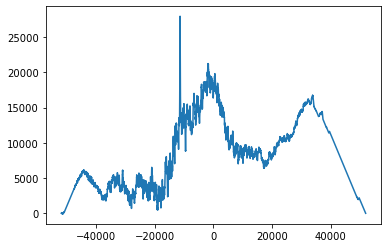

In [7]:
t_min = np.min([t_nav.min(), t_chrom.min()])
t_max = np.max([t_nav.max(), t_chrom.max()])
t_step = 1/60/20 #20Hz
t_min, t_max, t_step = np.round([t_min, t_max, t_step], 6)
t_comm = np.arange(t_min, t_max, t_step)

interp_chrom = scipy.interpolate.interp1d(t_chrom, chrom, bounds_error=False, fill_value=chrom[-1])
chrom_comm = interp_chrom(t_comm)

interp_nav = scipy.interpolate.interp1d(t_nav, dist, bounds_error=False, fill_value=dist[-1])
nav_comm = interp_nav(t_comm)

x_chrom = (chrom_comm/chrom_comm.max())>0.1
x_nav = nav_comm<40

x_chrom = 2*x_chrom-1
x_nav = 2*x_nav-1

corr = scipy.signal.correlate(x_chrom, x_nav)
lags = scipy.signal.correlation_lags(len(x_chrom), len(x_nav))
plt.plot(lags,corr)
print('required temporal shift:',lags[np.argmax(corr)]*t_step)


## Rest

In [ ]:
dist_thresh = 30
vel_thresh = 200
plt.figure(figsize=(12,2))
plt.plot(t_nav, dist<dist_thresh)
plt.xlim([t_nav.min(), t_nav.max()])
plt.show()
plt.figure(figsize=(12,2))
plt.plot(t_nav, (vel<vel_thresh) & (vel>0) )
plt.xlim([t_nav.min(), t_nav.max()])
plt.show()

In [ ]:
# t_nav[np.argmin(dist)]*60
# dist[np.argmin(dist)]
# ii = np.argmax(dist)
# plt.plot(dist[ii-10:ii+20])
# t_nav[ii+20]*60, dist[ii+20]
# dist.min()
print(t_nav[np.argsort(dist)][:4]*60)

In [ ]:
## load cautery status
file_mod = "Cautery status\\NP072_2_cautery_from_video.csv"
df_mod = pd.read_csv(file_loc+file_mod)
df_mod.head()

In [ ]:
cut = df_mod[df_mod.columns[1]].values
coag = df_mod[df_mod.columns[2]].values
t_mod = df_mod[df_mod.columns[0]].values

plt.figure(figsize=(12,2))
plt.plot(t_mod, coag)
plt.plot(t_mod, cut)
plt.xlim([t_mod.min(), t_mod.max()])
# plt.xlim([t_mod.min(), 20])
plt.show()

In [ ]:
## manual alignment
shift_nav2chrom = -9.5
t_min, t_max = 0, 35

plt.figure(figsize=(12,2))
plt.plot(t_chrom, chrom/chrom.max())
plt.plot(t_nav + shift_nav2chrom, dist<dist_thresh)
plt.xlim([t_min,t_max])
plt.legend(['chromatogram','near tumor'])
plt.show()

plt.figure(figsize=(12,2))
plt.plot(t_chrom, chrom/chrom.max())
plt.plot(t_nav + shift_nav2chrom, dist/dist.max())
plt.xlim([t_min,t_max])
plt.legend(['chromatogram','near tumor'])
plt.show()

In [ ]:
## manual alignment
shift_mod2chrom = 3.75

plt.figure(figsize=(12,2))
plt.plot(t_chrom, chrom/chrom.max())
plt.plot(t_mod + shift_mod2chrom, coag+cut)
plt.xlim([20,24])
plt.legend(['chromatogram','cautery on'])
plt.show()


In [ ]:
plt.figure(figsize=(12,2))
plt.plot(t_chrom, chrom/chrom.max())
plt.plot(t_nav + shift_nav2chrom, dist<dist_thresh)
plt.plot(t_mod + shift_mod2chrom, coag+cut)
plt.xlim([22,24])
plt.legend(['chromatogram','near tumor','cautery on'])
plt.show()


In [ ]:
## cautery unit orientation vector
dist_py = np.sqrt(np.sum( (ctr_tip-ndl_tip)**2,axis=1,keepdims=True))
ctr_unit_position = np.divide((ctr_tip-ndl_tip),dist_py)


In [ ]:
breast_side = 'R'
# R -> R==lateral, L-> R==Medial #

plt.figure(figsize=(12,2))
plt.plot(t_nav,ctr_unit_position)
plt.xlabel('time [minutes]')
plt.ylabel('distance [mm]')
plt.legend(['Lateral', 'Anterior', 'Superior']) 
plt.show()

In [ ]:
max_dist = 20
olors = np.clip(dist, 0, max_dist)/max_dist

ind =  (t_nav>0) & (t_nav<25)
tt = t_nav[ind] + shift_nav2chrom
dd = dist[ind]
# cc = colors[ind]
cc = np.clip(dd, 0, max_dist)/max_dist
step = 10
w = (tt[step]-tt[0])/2

plt.figure(figsize=(12,2))

plt.xlim([tt.min(), tt.max()])
plt.plot(t_chrom, chrom/chrom.max())
# plt.plot(t_nav+shift_nav2chrom, dist<dist_thresh)
# plt.plot(tt,cc)
plt.xlabel('time [minutes]')
# for i in range(step,len(tt)-step,step):
#     if (dist[i]<1000): #and locations[i]=='Anterior'):
#         plt.axvspan((tt[i]+tt[i-step])/2,(tt[i]+tt[i+step])/2,0,np.max(dist),color=colors[i],alpha=0.1)
for i in range(step,len(tt)-step,step):
    if (dd[i]<max_dist): #and locations[i]=='Anterior'):
        plt.axvspan(tt[i]-w,tt[i]+w,0,1,color=plt.get_cmap('Reds_r')(cc[i]))
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection = '3d')
colors = ctr_unit_position/2+0.5
# colors = np.abs(ctr_unit_position)
ax.scatter(ctr_unit_position.T[0], ctr_unit_position.T[1], ctr_unit_position.T[2], c=colors.T[2], cmap='seismic')
plt.show()


In [ ]:
ind =  (t_nav>0) & (t_nav<25)
tt = t_nav[ind] + shift_nav2chrom
dd = dist[ind]
cc = colors[ind]
step = 10
w = (tt[step]-tt[0])/2

plt.figure(figsize=(12,2))

plt.xlim([tt.min(), tt.max()])
plt.plot(t_chrom, chrom/chrom.max())
# plt.plot(t_nav+shift_nav2chrom, dist<dist_thresh)
plt.xlabel('time [minutes]')
# for i in range(step,len(tt)-step,step):
#     if (dist[i]<1000): #and locations[i]=='Anterior'):
#         plt.axvspan((tt[i]+tt[i-step])/2,(tt[i]+tt[i+step])/2,0,np.max(dist),color=colors[i],alpha=0.1)
for i in range(step,len(tt)-step,step):
    if 1: #(dd[i]<dist_thresh): #and locations[i]=='Anterior'):
        plt.axvspan(tt[i]-w,tt[i]+w,0,1,color=plt.get_cmap('seismic')(colors[i,2]))
plt.show()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider, FloatSlider, Layout

# def dist_thresholding(t_nav, dist, dist_thresh):
#     plt.figure(figsize=(12,2))
#     plt.plot(t_nav, dist<dist_thresh)
#     plt.xlim([t_nav.min(), t_nav.max()])
#     plt.show()
# aa = interact(dist_thresholding, t_nav = fixed(t_nav), dist = fixed(dist), dist_thresh=(0, 100))

def dist_thresholding(shift, dist_thresh, t_start, t_width):
    plt.figure(figsize=(12,2))
    plt.title('chromatogram', loc='left')
    plt.plot(t_chrom, chrom/chrom.max())
    plt.xlim([t_start,t_start+t_width])
    plt.yticks([])
    plt.figure(figsize=(12,2))
    plt.title('cautery in '+str(dist_thresh)+' mm vicinity of tumor', loc='left')
    plt.plot(t_nav + shift, dist<dist_thresh)
#     plt.plot(t_nav + shift, dist/dist.max())
    plt.xlim([t_start,t_start+t_width])
    plt.yticks([])
    plt.xlabel('time (minutes)')
    plt.show()
#     plt.figure(figsize=(12,2))
#     plt.plot(t_chrom, chrom/chrom.max())
#     plt.plot(t_nav + shift, dist<dist_thresh)
#     plt.xlim([t_start,t_start+t_width])
#     plt.show()

aa = interact(dist_thresholding,
              shift = FloatSlider(value=-9.50, min=-15.0, max=15.0,step=0.01, layout=Layout(width='600px')),
              dist_thresh = IntSlider(value=30, min=0, max=200, step=1, layout=Layout(width='600px')),
              t_start = IntSlider(value=23, min=0, max=30, step=1, layout=Layout(width='600px')),
              t_width = IntSlider(value=6, min=5, max=50, step=1, layout=Layout(width='600px')),)

In [ ]:
(28.09+9.5)*60

In [ ]:
1894/60-9.5

In [ ]:
plt.colormaps()[1]

In [ ]:
ctr_reduced_position = []
for vec in ctr_unit_position:
    ind = np.argmax(np.abs(vec))
    if vec[ind]<0:
        ind = ind+3
    ctr_reduced_position.append(ind)

ctr_reduced_position = np.array(ctr_reduced_position)
ctr_reduced_position.shape = (-1,1)

plt.figure(figsize=(10,4))
plt.plot(t,ctr_reduced_position)
plt.xlabel('time [minutes]')
plt.show()

In [ ]:
text_ref = ['Lateral', 'Anterior', 'Superior', 'Medial', 'Posterior', 'Inferior']
color_ref = ['r','g','b','m','y','c']

colors = [color_ref[int(x)] for x in ctr_reduced_position]
locations = [text_ref[int(x)] for x in ctr_reduced_position]

In [ ]:
nn = len(t)
tt = t[:nn]
aa = np.ones(tt.shape)*np.max(dist)
cc = colors[:nn]
# width = (tt[1]-tt[0])*0.9

plt.figure(figsize=(10,4))
plt.plot(tt,dist_py[:nn], 'k')
# for i,x in enumerate(tt):
#     plt.axvspan(x-width/2,x+width/2,0,np.max(dist),color=colors[i],alpha=0.5)
# plt.bar(tt,aa,width,color=cc, alpha = 0.5)
# plt.xlim([20,25])
plt.ylim([0,1000])
# plt.xlim([15,30])
plt.xlabel('time [minutes]')
plt.ylabel('distance [mm]')
for i in range(1,len(tt)-1):
    if (dist[i]<1000): #and locations[i]=='Anterior'):
        plt.axvspan((tt[i]+tt[i-1])/2,(tt[i]+tt[i+1])/2,0,np.max(dist),color=colors[i],alpha=0.1)
plt.show()

In [ ]:
## save the orientations
df['Cautery Location'] = locations
new_file = "Case16_positionMatrix_v4.csv"
df.to_csv(file_loc+new_file)

In [ ]:
l,c = np.unique(locations, return_counts=True)
for x,y in zip(l,c/np.sum(c)*100):
    print(x,y)